# Policy Gradient 套用到 Breakout 上
---
注意！！  
Breakout 只能在 linux or mac 上面跑  

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import gym
from datetime import timedelta
import time
import random
import os

from skimage import transform
from RLAgent_DeepQNetwork_CNN import DeepQNetwork

Observaton space: (210, 160, 3)
Action: 4
['NOOP', 'FIRE', 'RIGHT', 'LEFT']


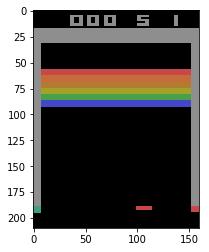

In [2]:
# 創建環境
# 為了讓資料可以重複製造
# 所以可以設定亂數
env = gym.make("Breakout-v4")
env.seed(6)
imgShape = env.observation_space.shape
numAction = env.action_space.n

# Print 結果
# 記得！！ shape(0) => rows(height), shape(1) => cols(width)
print("Observaton space: " + format(imgShape))
print("Action: " + format(numAction))
print(env.unwrapped.get_action_meanings())

# 顯示測試
img = env.reset()
plt.imshow(img)
plt.show()

# 測試動作
---

In [3]:
# 因為 matplotlib 在顯示大的圖片會比較慢，所以 scale 一下圖會比較快
plotScale = 10
fontSize = 15

In [4]:
# 分成五格看
def ShowAction(action):
    fig, axes = plt.subplots(1, 5)

    # 顯示設定
    # 記得！！ shape(0) => rows(height), shape(1) => cols(width)
    fig.set_figwidth(imgShape[1] / plotScale)
    fig.set_figheight(imgShape[0] / plotScale)
    fig.subplots_adjust(wspace=0.5)

    # 先歸零，在做第 0 個動作
    img = env.reset()
    axes[0].imshow(img)
    axes[0].set_xlabel("Start", fontsize = fontSize)
    for i in range(1, 5):
        img, reward, IsDone, Info = env.step(action)
        axes[i].imshow(img)

        info = "Reward: " + format(reward) + "\nIsDone: " + format(IsDone) + "\nInfo: " + format(Info)
        axes[i].set_xlabel(info, fontsize = fontSize)

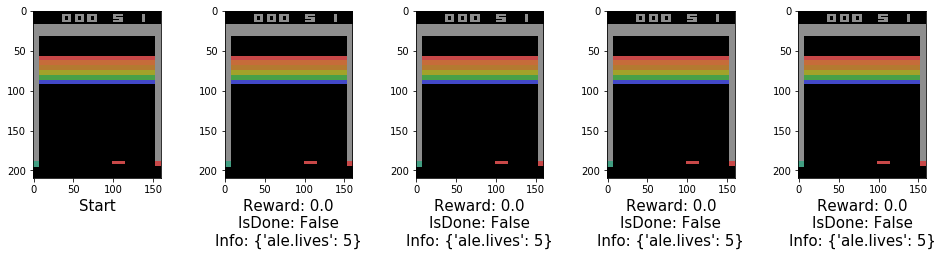

In [5]:
# no-op
ShowAction(0)

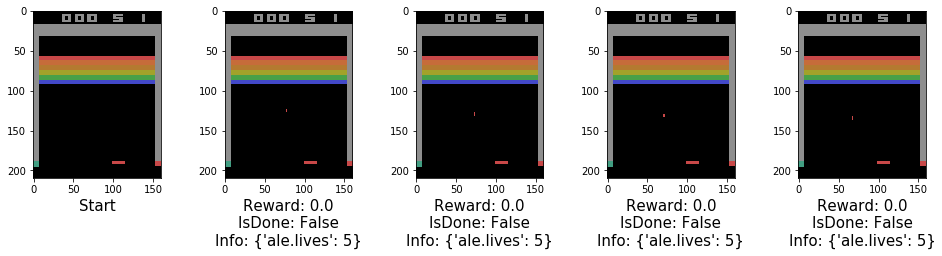

In [6]:
# Fire
ShowAction(1)

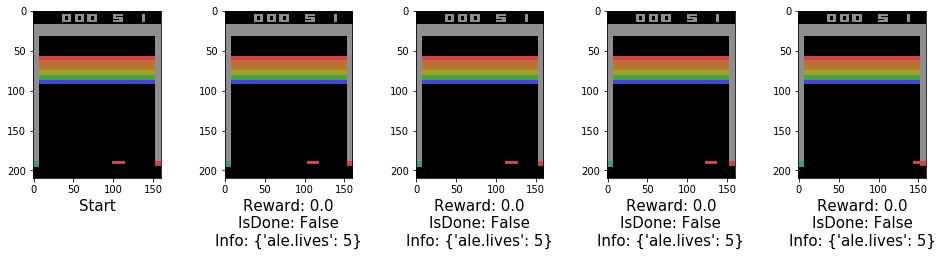

In [7]:
# Right
ShowAction(2)

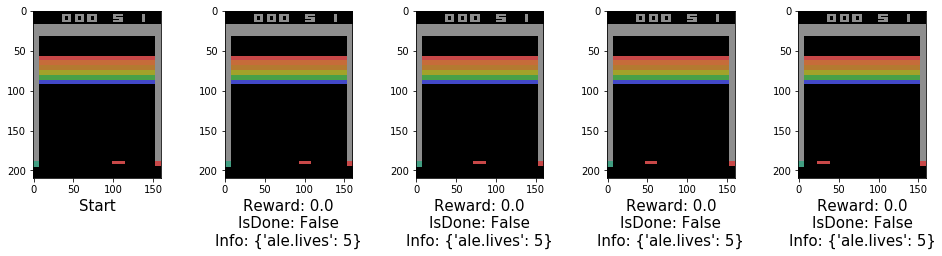

In [8]:
# Left
ShowAction(3)

## 對圖片做處理
---
因為圖片太大了  
而且 Features 也不是很多  
所以會先轉成灰階在縮小

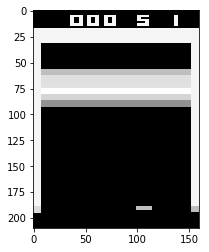

In [9]:
# 去掉顏色的 Feature
def img2gray(img):
    value = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
    return value

# 測試顯示出來世不是灰階
plt.imshow(img2gray(env.reset()), cmap="gray")
plt.show()

(105, 80)


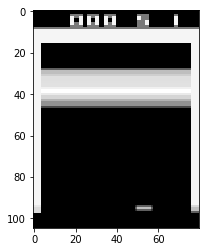

In [10]:
# 重新縮小 k 倍
# 記得！！ shape(0) => rows(height), shape(1) => cols(width)
smallSize = 2
smallSizeArray = (int(imgShape[0] / smallSize), int(imgShape[1] / smallSize))
def reshapeImg(img):
    smallImg = transform.resize(img, smallSizeArray, mode="constant")
    return smallImg

print(smallSizeArray)
plt.imshow(reshapeImg(img2gray(env.reset())), cmap="gray")
plt.show()

In [11]:
# 圖片處理
def ImagePreprocess(img):
    grayImg = img2gray(img)
    
    # 如果圖片沒有這個 Scale 成 0 ~ 1，會導致輸出的結果爆掉 
    outputImg = reshapeImg(grayImg) / 255
    return outputImg

In [12]:
# plot 的 PastImage
def plotPastImage(imgArray):
    depth = imgArray.shape[0]
    
    # 測試
    fig, axes = plt.subplots(1, depth)
    
    fig.set_figwidth(imgShape[1] / plotScale)
    fig.set_figheight(imgShape[0] / plotScale)
    fig.subplots_adjust(wspace=0.5)
    
    for i in range(0, depth):
        axes[i].imshow(imgArray[i, :, :, 0], cmap="gray")  
    plt.show()

In [13]:
# 為了把東西加進去
def pushInPastImage(PastImage, processedImg):
    # 變成 4 維的資料
    processArray = np.reshape(processedImg,(1, processedImg.shape[0], processedImg.shape[1], 1))
    
    # 刪掉最前面的，並加在最後面
    PastImage = np.delete(PastImage, 0, 0)
    PastImage = np.concatenate((PastImage, processArray), axis = 0)
    return PastImage

## 開始見 AI 來訓練
---

In [14]:
# 設定輸入的參數
# 單張輸入大小
# 記得！！ shape(0) => rows(height), shape(1) => cols(width)
SingleInputSize = smallSizeArray[0] * smallSizeArray[1]
# 輸入幾張圖片
InputImageSize = 5

In [15]:
Agent = DeepQNetwork(
    # 試試看取消發射鍵
    n_actions = numAction - 1,
    imgRows = smallSizeArray[0],
    imgCols = smallSizeArray[1],
    imgNumber = InputImageSize,
    imgChannel = 1,
    
    LearningRate=1e-2,
    e_greedy_increment = 0.01,
    memory_size = 2000,
    # IsOutputGraph=True
)

In [16]:
Agent.RestoreModel()

INFO:tensorflow:Restoring parameters from ./models/Deep Q Network-10000


In [17]:
# 叫紀錄遊玩的過去 n 個 Frame 的資料
# [n張圖片, 高, 寬, channel]
PastImage = np.zeros((InputImageSize, smallSizeArray[0], smallSizeArray[1], 1), dtype = np.uint8)

## 讓他自己玩
---

In [18]:
# 顯示 global epoch （(回合
globalEpoch = 10000

# 根據 Memory 庫中，看有幾個動作
moveStep = 0

# 最少要用的個數
minimumTrainStep = 300

In [19]:
# 根據前面亂玩的結果
# 想辦法不要掉在 local minimum 中
def TrainModel(epoch, IsRendering = False):
    global PastImage, globalEpoch, moveStep, minimumTrainStep
    
    # 計算時間
    startTime = time.time()
    
    # 紀錄亂玩次數
    epochCounter = 0
    
    # Score List
    scoreList = []
    
    while epochCounter < epoch:
         # 重新開始，先把 PastImage 初始化
        observation = env.reset()
        
        # 處理圖片
        processOb = ImagePreprocess(observation)

        # 先產生開始圖片 n - 1 張
        # 因為輸入要是 n 張圖片
        # n 張圖要放開球的圖片
        for picIndex in range(0, InputImageSize - 1):
            PastImage = pushInPastImage(PastImage, processOb)
        
        # 開球
        observation, reward, IsDone, Info = env.step(1)
        processOb = ImagePreprocess(observation)
        
        if(IsRendering):
            env.render()
        
        # 紀錄命
        lastFrameLive = 5
        
        # 這個回合得到的分數
        thisEpochScore = 0
        
        while True:
            # 產生前 n 筆的資料當輸入，選擇動作
            PastImage = pushInPastImage(PastImage, processOb)
            
            action = Agent.chooseAction(PastImage)
            
            # 實際執行的動作
            doAction = 0
            if(action >= 1):
                doAction = action + 1
                
            # 當死掉的時候，要重新按下發射
            if (lastFrameLive != env.unwrapped.ale.lives()):
                doAction = 1
                lastFrameLive = env.unwrapped.ale.lives()
            
            nextOberservation, reward, IsDone, Info = env.step(doAction)
            
            # 計算分數
            thisEpochScore += reward
            
            if(IsRendering):
                env.render()

            nextProcessOb = ImagePreprocess(nextOberservation)
            nextProcessArray = np.reshape(nextProcessOb, (1, nextProcessOb.shape[0], nextProcessOb.shape[1], 1))

            # 如果不是按下 Fire ，都存到 Memory 裡
            if (doAction != 1):
                Agent.storeTransition(
                    observation = PastImage,
                    reward = reward,
                    action = action,
                    nextObservation = np.concatenate((PastImage[1:5], nextProcessArray), axis = 0)
                )
            
            # DQN 學習的機制
            if(moveStep > minimumTrainStep and moveStep % 5 == 0):
                Agent.learn()
            
            # 如果命用完了，就會跑到 IsDone
            # 先設定他失敗一次之後就結束
            if(IsDone):
                
                epochCounter += 1
                globalEpoch += 1
                
                scoreList.append(thisEpochScore)
                break
                
            # 總共有幾個動作
            moveStep += 1

            # 覆蓋掉以前的部分
            processOb = nextProcessOb
    
    # 訓練結束，把資料刪掉
    if(IsRendering):
        env.render(close = True)
    
    # 顯示分數走向
    plt.title(format(globalStep - epoch) + " ~ " + format(globalStep))
    plt.plot(scoreList)
    plt.show()
    
    # 列印出時間
    endTime = time.time()
    time_diff = endTime - startTime
    timeStr = "Time usage: " + str(timedelta(seconds=int(round(time_diff))))
    print(timeStr)

In [20]:
# 每 100 存一個 Model
# 執行 10000次
for i in range(0, 100):
    TrainModel(
        10000,
        IsRendering = True
    )
    Agent.SaveModel(globalStep)


KeyboardInterrupt



## 測試已經做完的模型
---

In [ ]:
# 跑以訓練完的模型
def RunModel():
    global PastImage
    
    # 計算時間
    startTime = time.time()
    
    # Score List
    scoreList = []
    
    # 重新開始，先把 PastImage 初始化
    observation = env.reset()
        
    # 處理圖片
    processOb = ImagePreprocess(observation) 

    # 先產生開始圖片 n - 2 張，因為輸入要是 n 張圖片
    # n-1 張圖要放開球的圖片
    for picIndex in range(0, InputImageSize - 2):
        PastImage[picIndex, :, :, 0] = processOb
        
    # 處理 n-1 張圖片
    observation, reward, IsDone, Info = env.step(1)
    processOb = ImagePreprocess(observation) 
    PastImage[InputImageSize - 2, :, :, 0] = processOb
        
    env.render()
        
    # 紀錄命
    lastFrameLive = 5
        
    while True:
        # 產生前 n 筆的資料當輸入，選擇動作
        processObArray = np.reshape(processOb,(1, processOb.shape[0], processOb.shape[1], 1))
        PastImage = np.concatenate((PastImage, processObArray), axis = 0)
            
        action = Agent.chooseAction(PastImage, IsTraining=False)
            
        # 實際執行的動作
        doAction = 0
        if(action >= 1):
            doAction = action + 1
                
        # 當死掉的時候，要重新按下發射
        if (lastFrameLive != env.unwrapped.ale.lives()):
            doAction = 1
            lastFrameLive = env.unwrapped.ale.lives()
            
        nextOberservation, reward, IsDone, Info = env.step(doAction)
        
        env.render()

        nextProcessOb = ImagePreprocess(nextOberservation)
        nextProcessArray = np.reshape(nextProcessOb, (1, nextProcessOb.shape[0], nextProcessOb.shape[1], 1))
            
        # 如果命用完了，就會跑到 IsDone
        # 先設定他失敗一次之後就結束
        if(IsDone):
            # 並刪掉最前面的 Image
            PastImage = np.delete(PastImage, 0, 0)
            break

        # 覆蓋掉以前的部分
        processOb = nextProcessOb

        # 並刪掉最前面的 Image
        PastImage = np.delete(PastImage, 0, 0)
    
    # 訓練結束，把資料刪掉
    env.render(close = True)
    
    # 列印出時間
    endTime = time.time()
    time_diff = endTime - startTime
    timeStr = "Time usage: " + str(timedelta(seconds=int(round(time_diff))))
    print(timeStr)

In [ ]:
# # Test Result
# PastImage = np.zeros((InputImageSize - 1, smallSizeArray[0], smallSizeArray[1], 1), dtype = np.uint8)
# RunModel()